# Interactive Topic Model (ITM) Vignette

This notebook demonstrates the use of the Interactive Topic Model (ITM) on a subset of the DBpedia dataset. We'll walk through loading data, fitting the model, exploring and refining topics, and checking how well the model did.

**Sections:**
- [Preparation](#Preparation)
    - [Load Data](#Load-Data)
    - [Prepare Texts for Modeling](#Prepare-Texts-for-Modeling)
- [Model Initialization & Fitting](#Model-Initialization-&-Fitting)
    - [Fit the Model](#Fit-the-Model)
    - [Visualize Topic Hierarchy](#Visualize-Topic-Hierarchy)
    - [Visualize Documents](#Visualize-Documents)
    - [Topic Summary Table](#Topic-Summary-Table)
- [Some Metrics](#Some-Metrics)
- [Interacting with the Topic Model](#Interacting-with-the-Topic-Model)
    - [Representative Documents](#Representative-Documents)
    - [Examples](#Examples)
    - [Labeling](#Labeling)
    - [Semantic Search](#Semantic-Search)
    - [Creating Topics](#Creating-Topics)
    - [Automatically Recomputed Representations](#Automatically-Recomputed-Representations)
    - [Splitting](#Splitting)
        - [Previewing Splits](#Previewing-Splits)
        - [Using Different Embedding Models](#Using-Different-Embedding-Models)
        - [Committing Splits](#Committing-Splits)
    - [Suggested Reassignments](#Suggested-Reassignments)
    - [Manual Reassignments](#Manual-Reassignments)
- [Final Comparisons](#Final-Comparisons)

## Preparation

First we import the necessary libraries and load data.

In [1]:
import pandas as pd
from interactive_topic_model import *

print("Imports successful")

Imports successful


### Load Data

This code generates the data if you don't already have it. You'll need `datasets` to access the DBpedia dataset. I select 5 target categories, and sample documents for each. These selected topics are intentional--I'm thinking `EducationalInstitution` and `Building` will be interesting to untangle. As will `Artist` and `Athlete`. And `Plant` is there as low-hanging fruit.

In [2]:
chosen_labels = [
    "EducationalInstitution",
    "Artist",
    "Athlete",
    "Building",
    "Plant"
]

try:
    data = pd.read_csv("dbpedia_sampled.csv")
    print("Loaded existing sampled dataset")
except FileNotFoundError:
    print("Creating dataset")

    import numpy as np
    from datasets import load_dataset

    dataset = load_dataset("dbpedia_14", split="train")

    label_name_to_id = {
        name: idx for idx, name in enumerate(dataset.features["label"].names)
    }

    chosen_label_ids = [label_name_to_id[name] for name in chosen_labels]

    seed = 42
    n_per_topic = 100

    rng = np.random.default_rng(seed)

    dfs = []

    for label_id, label_name in zip(chosen_label_ids, chosen_labels):
        subset = dataset.filter(lambda x: x["label"] == label_id)

        # reproducible shuffle
        indices = rng.permutation(len(subset))[:n_per_topic]
        sampled = subset.select(indices)

        df = pd.DataFrame({
            "text": sampled["content"],
            "label": label_name
        })

        dfs.append(df)

    data = pd.concat(dfs, ignore_index=True)
    data.to_csv("dbpedia_sampled.csv", index=False)

    print("Dataset created and saved")

Loaded existing sampled dataset


Now that we've got our sample, let's take a quick look at a few example documents from each category. This helps us get a feel for what the data actually looks like before we dive into modeling.

In [3]:
for label in chosen_labels:
    print(f"\n{'='*80}")
    print(f"Topic: {label}")
    print(f"{'='*80}")
    for i in range(3):
        print(f"\nDoc {data[data['label'] == label].index[i]}:")
        text = data[data['label'] == label]['text'].iloc[i]
        print(text[:500] + "..." if len(text) > 500 else text)


Topic: EducationalInstitution

Doc 0:
 The Andalusian School of Public Health (Spanish language acronym: EASP) is a public institution which provides training consultancy and research services for the healthcare sector. It is located in Granada (Spain) on the University campus. It is a state-owned enterprise promoted by the Andalusian government.

Doc 1:
 The New Delhi Institute of Management is a private not for profit business school that is located in Tughlakabad New Delhi. Established in 1992 NDIM offers AICTE approved 2 years full-time PGDM. The PGDM at NDIM is recognised equivalent to MBA is accredited by the National Board of Accreditation(NBA). The main Campus offering PGDM is at 60 50 (B & C) Tughlakabad Institutional Area New Delhi.

Doc 2:
 Ramakrishna Mission Vidyapith Purulia India is a branch of the Ramakrishna Mission. It is a residential school for boys running under the Gurukul system. It was founded by Swami Hiranmayananda in 1958. The then chief minister of West Ben

### Prepare Texts for Modeling
Next, let's pull out just the text column from our dataframe. This is what we'll actually feed into ITM.

In [4]:
texts = data['text'].tolist()

print(f"Loaded {len(texts)} documents")

Loaded 500 documents


## Model Initialization & Fitting <a id="Model-Initialization-&-Fitting"></a>

Alright, time to initialize the Interactive Topic Model! We'll pass in our list of texts and get ready to fit the model. If you are happy with the default settings, it's as simple as this!

In [5]:
itm = InteractiveTopicModel(texts)
itm

InteractiveTopicModel(not fitted, docs=500, topics=0, assigned=0)

### Fit the Model

Now let's fit the model. This step may take a minute or two depending on your machine--my laptop takes 15 seconds.

In [6]:
# Fit the model
itm.fit()
itm

InteractiveTopicModel(fitted, docs=500, topics=3, assigned=500)

### Visualize Topic Hierarchy

Let's explore the discovered topic structure using a dendrogram or hierarchy plot. Nothing much to see though--just three very different topics!

(<Figure size 800x400 with 1 Axes>,
 <Axes: title={'center': 'Topic Hierarchy'}>)

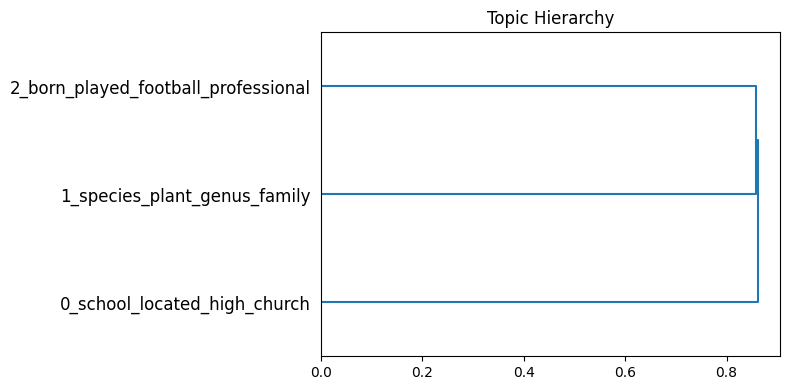

In [7]:
itm.visualize_topic_hierarchy()

### Visualize Documents

We can also project documents into a 2D space to explore their distribution and topic assignments. This Plotly.js plot allows you to hover over the points to see the text!

In [8]:
itm.visualize_documents()

### Topic Summary Table

Let's take a look at a summary table of the topics ITM found. This will show us the top words for each topic and how many documents belong to each.

In [9]:
# Get topic summary
topic_info = itm.get_topic_info(top_words_n=10)
print(f"Discovered {len(topic_info)} topics\n")
topic_info

Discovered 4 topics



,topic_id,label,count,top_terms
0,-1,OUTLIERS,0,
1,0,0_school_located_high_church,199,"school, located, high, church, university, hig..."
2,1,1_species_plant_genus_family,100,"species, plant, genus, family, endemic, native..."
3,2,2_born_played_football_professional,201,"born, played, football, professional, american..."


## Some Metrics

Let's see how well our discovered topics match the original categories. This is just a sanity check--in a real-world application, there won't be a correct classification check against. Moreover, the goal of the Iterative Topic Model is exploration, and later we'll find that there might be more to these categories.

In [10]:
# Build comparison between ITM topics and "true" categories
def validate_topics(itm, data):
    """Compare ITM topics with ground truth labels."""

    from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
    

    # Get ITM assignments (excluding outliers for metrics)
    itm_labels = itm._assignments.copy()
    true_labels = data['label'].values
    
    # Mask for non-outliers
    non_outlier_mask = itm_labels != itm.OUTLIER_ID
    
    # Compute clustering metrics (on non-outliers only)
    ari = adjusted_rand_score(true_labels[non_outlier_mask], itm_labels[non_outlier_mask])
    nmi = normalized_mutual_info_score(true_labels[non_outlier_mask], itm_labels[non_outlier_mask])
    
    print("="*60)
    print("CLUSTERING QUALITY METRICS (excluding outliers)")
    print("="*60)
    print(f"Adjusted Rand Index (ARI): {ari:.3f}")
    print(f"  - Perfect: 1.0, Random: ~0.0")
    print(f"Normalized Mutual Information (NMI): {nmi:.3f}")
    print(f"  - Perfect: 1.0, No mutual info: 0.0")
    print()
    
    return ari, nmi

ari, nmi = validate_topics(itm, data)

CLUSTERING QUALITY METRICS (excluding outliers)
Adjusted Rand Index (ARI): 0.610
  - Perfect: 1.0, Random: ~0.0
Normalized Mutual Information (NMI): 0.783
  - Perfect: 1.0, No mutual info: 0.0



In [11]:
# Create cross-tabulation: ITM topics vs true categories
def topic_category_crosstab(itm, data):
    """Create crosstab of ITM topics vs ground truth categories."""
    
    results = []
    for doc_id in data.index:
        pos = itm._pos(doc_id)
        topic_id = int(itm._assignments[pos])
        topic_label = itm.topics[topic_id].label if topic_id in itm.topics else f"Topic {topic_id}"
        
        results.append({
            'doc_id': doc_id,
            'itm_topic_id': topic_id,
            'itm_topic_label': topic_label,
            'true_category': data.loc[doc_id, 'label']
        })
    
    df = pd.DataFrame(results)
    
    # Create crosstab
    crosstab = pd.crosstab(
        df['itm_topic_label'], 
        df['true_category'],
        margins=True
    )
    
    return df, crosstab

comparison_df, crosstab = topic_category_crosstab(itm, data)
print("Cross-tabulation: ITM Topics vs True Categories")
print("="*80)
crosstab

Cross-tabulation: ITM Topics vs True Categories


true_category,Artist,Athlete,Building,EducationalInstitution,Plant,All
itm_topic_label,,,,,,
0_school_located_high_church,0,0,100,99,0,199
1_species_plant_genus_family,0,0,0,0,100,100
2_born_played_football_professional,100,100,0,1,0,201
All,100,100,100,100,100,500


## Interacting with the Topic Model

Now let's get into the fun of it! After all, the whole point is to use ITM to learn more about our collection of documents.


### Representative Documents

Let's start by checking the representative documents for each topic. Each topic has a number of representative documents that serve as the core of the topic--by default this number is set at 3 at initialization. If you're expecting a broader range of documents in each topic, you can increase this number.

In [12]:
# Get representative documents for each topic
representative_docs = itm.get_representative_documents()

for (topic_id, label), texts in representative_docs.items():
    print(f"\n{'='*80}")
    print(f"Topic {topic_id}: {label}")
    print(f"{'='*80}")
    for i, text in enumerate(texts, 1):
        print(f"\nDoc {i}:")
        print(text[:400] + "..." if len(text) > 400 else text)


Topic 0: 0_school_located_high_church

Doc 1:
 Charles La Trobe College is not a public co-educational high school in Macleod Victoria Australia. It opened in 2012 the result of a merger between Banksia La Trobe Secondary College Bellfield Primary School Haig Street Primary School and Olympic Village Primary School.

Doc 2:
 All Saints Academy is a catholic primary elementary and junior high school located in the Roman Catholic Diocese of Belleville. The categories are: pre-k to kindergarten 1st and 2nd grades (primary building) 3rd 4th and 5th (elementary) and 6th 7th and 8th (junior high). The school mascot is the Saints.

Doc 3:
 South Reading Academy is a historic former school building at 7 Foster Street in Wakefield Massachusetts in the United States. The large two story wood frame structure was built c. 1828–29 for the First Baptist Church as an academy and meeting house and was one of the earliest of its kind. The Baptists used it until 1847 when the town acquired the building

### Examples

And here are a few example documents for each topic. Even if the representative docs make sense, topics may also include wildly different things. This is why checking a random sample of examples is a great way to qualitatively check topic coherence.

In [13]:
# Get example documents for each topic
examples = itm.get_examples(n=3, random_state=42)

for (topic_id, label), texts in examples.items():
    print(f"\n{'='*80}")
    print(f"Topic {topic_id}: {label}")
    print(f"{'='*80}")
    for i, text in enumerate(texts, 1):
        print(f"\nExample {i}:")
        print(text[:400] + "..." if len(text) > 400 else text)


Topic 0: 0_school_located_high_church

Example 1:
 St Martin's Church Brampton is in Front Street Brampton Cumbria England. It is an active Anglican parish church in the deanery of Brampton the archdeaconry of Carlisle and the diocese of Carlisle. It is designated by English Heritage as a Grade I listed building and is the only church designed by the Pre-Raphaelite architect Philip Webb. The architectural historian Nikolaus Pevsner described it a...

Example 2:
 Heath Grammar School Free School Lane Halifax West Yorkshire England was founded in 1585 by Dr. John Favour. Its full title was The Free Grammar School of Queen Elizabeth at Heath near Halifax.

Example 3:
 The Bramalea City Centre is a large shopping mall located in the city of Brampton Ontario Canada. With over a 1.5 million square feet of retail space and more than 300 outlets it is one of Canada's largest shopping malls.

Topic 1: 1_species_plant_genus_family

Example 1:
 Bulbophyllum nitens is a species of orchid in the g

### Labeling

An important part of exploration is labeling topics. This forces us to check what's in each topic, which we did above. Often topics are heterogeneous and contain a mix of different ideas I would like to see as separate topics. In those cases, I make a note of that in the label. But for our test data, it's pretty cleanly separated into three categories.

While you can label each topic individually, e.g.:

```
itm.topics[0].label = 'Places'
```

I prefer to do them in bulk for my first pass, which ITM has a useful function for. That was I encourage myself to look over all the topics too!

In [14]:
labels = {
    0: "Places",
    1: "Plants",
    2: "People"
}

itm.label_topics(labels)

### Semantic Search

Now that we've labeled our documents, we can start checking if individual topics can be further broken down. For example, I noticed a bunch of sports examples earlier in the `People` topic (I swear it's not because I know the "right answer" 😆), so I can do a semantic search--i.e., searching using meaning as opposed to checking for a specific sequence of characters like traditional searches--in the topic. It's extra nice to be able to do this with a visualization, where the color indicates how similar each document is to my search text.

In [15]:
itm.topics[2].visualize_documents_with_search("They are an athlete.")

I can also do a search for artists, which seems to be everyone else. More or less, we have an inversion in colors. Cool!

In [16]:
itm.topics[2].visualize_documents_with_search("They are an artist.")

I can also get the concrete similarity values (from -1 to 1). Here, I get the values for both.

In [17]:
sims = itm.similarity_search(["They are an athlete.", "They are an artist."])
sims.head()

,doc_id,text,topic_id,label,sim_0,sim_1
280,280,Marco Rodolfo Matellini Walker (born January ...,2,People,0.375313,0.159562
255,255,Charles Frederick Theodore Snelling (born Sep...,2,People,0.362908,0.198986
296,296,Wang Jing-li (Chinese: 王勁力; born September 7 ...,2,People,0.349730,0.177706
213,213,John Carlos Matanguihan Hermida Jr. better kn...,2,People,0.347022,0.136013
245,245,Ivan Angelov (Bulgarian: Иван Ангелов; born J...,2,People,0.343547,0.141127


Next, I combine them to get a stronger measure for whether we're looking at an athlete (think of this as how much this person is an athlete and how much they're *not* an artist). Looking through this list, I find that when the combined score is above 0, then I'm pretty sure that I have an athlete.

In [18]:
sims['combined'] = sims.sim_0 - sims.sim_1
sims = sims[sims.topic_id == 2]
sims = sims.sort_values(by='combined', ascending=False)
sims.iloc[90:110]

,doc_id,text,topic_id,label,sim_0,sim_1,combined
275,275,Pio Marchi (born 1895) was an Italian profess...,2,People,0.197331,0.128532,0.068799
212,212,Mudashiru Babatunde Muda Lawal (8 June 1954 i...,2,People,0.197627,0.129965,0.067662
226,226,Eddy Silvestre Pascual Israfilov also known a...,2,People,0.197374,0.130659,0.066715
215,215,Lewis Vaughan (born 19 December 1995) in Edin...,2,People,0.145312,0.088229,0.057082
239,239,Kin Taiei (Korean: 김태영 Hanja: 金泰泳; born July ...,2,People,0.239680,0.185354,0.054326
288,288,Michal Birner (born March 2 1986) is an Czech...,2,People,0.162088,0.118579,0.043508
273,273,Raphael Matos (born August 28 1981) is a Braz...,2,People,0.199818,0.161979,0.037839
243,243,William Alvin Moody (April 10 1954 – March 5 ...,2,People,0.209762,0.201590,0.008172
162,162,Kenneth A. Radnofsky (born July 31 1953 Bryn ...,2,People,0.157301,0.151517,0.005784
214,214,Alexandre Cacareco Ferreira born in Rio de Ja...,2,People,0.218587,0.221659,-0.003071


### Creating Topics

Using the table we made earlier, I can get a list of IDs of texts that are athletes. I then use those to create a new topic called `Athletes`.

In [19]:
to_assign = sims[sims.combined > -0.0082].doc_id.tolist()
itm.create_topic('Athletes', to_assign)

InteractiveTopic(id=3, 'Athletes', active, n=100)

Ta-dah! Now the cluster at the top has been split into two.

In [20]:
itm.visualize_documents()

### Automatically Recomputed Representations

Remember how each topic has representative docs? Well those (along with other representations--ways in which we characterize each topic like top words and other numerical things like cTFIDF) get recalculated once we move documents around. For example, we moved our athletes out from the `People` topic, and now we can see the representative docs there have changed. Now, they're centered around artists!

In [21]:
itm.topics[2].get_representative_docs()

[' Marcus Blake is an American Los Angeles based musician and songwriter. He is primarily a bass guitarist but also sings lead and backing vocals and plays guitar. Blake has written played recorded and toured with numerous bands and artists and musical luminaries since 1993 including: Mother Superior Rollins Band Daniel Lanois Sparks Pearl Meat Loaf Alice Cooper Tony Visconti Emmylou Harris Wayne Kramer and George Clinton.',
 " Kealii Blaisdell (born July 16 1972 in Honolulu Hawai'i) multiple Na Hoku Hanohano Finalist (Hawaiian Academy of Recording Arts) for Most Promising Artist and Hawaiian Language Performance Hawaiian slack key guitarist recording artist and music composer. A prolific composer of the Native Hawaiian music genre with over 130 original Traditional Hawaiian Songs and a Native Hawaiian Activist.",
 ' Z. Randall Stroope (born October 25 1953) is an American composer conductor and lecturer. He has published more than 125 pieces with: Oxford University Press Alliance Musi

Let's check examples to be sure. And yup, all artists!

In [22]:
itm.topics[2].get_examples()

[" Adam Kury (born July 7 1969) is a bassist and vocalist based in Los Angeles California. He has performed with notable acts such as Candlebox Legs Diamond Jagger Cook and several others. He also performed music for the movie Gone Fishin'. During his long and prosperous career Kury has performed for such big names as Queen Victoria Barack Obama and Hillary Clinton. Adam currently works in numerous projects/bands including Candlebox The Kings Royal 7th Sun and Whipped Cream.",
 ' Terrence Terry Kavanagh (born July 9) is an American comic book editor and writer.',
 ' William Henry Hitchener is a British author.He had two book] published in 1813 St. Leonard’s Forest Vol 1.2 (London Chapple 1813 ISBN 3-628-47673-9) and The Tower of Ravenwold Vol 1.2 (London Chapple 1813 ISBN 3-628-47674-7). Both books are travel books.',
 ' Tetsu Shiratori (白鳥 哲 Shiratori Tetsu born March 21 1972 in Tokyo) is a Japanese voice actor.',
 ' Stefano Langone (born February 27 1989) is an American singer from K

So let's go ahead and relabel that.

In [23]:
itm.topics[2].label = 'Artists'

### Splitting

We can also automatically split a large enough topic but running *another* topic model inside it! For example, we had a large `Places` topic. Let's try to split that.

In [24]:
itm.topics[0].visualize_documents()

#### Previewing Splits

First, we preview a split--that is, we get to examine the proposed split before it's actually implemented. This allows us to try different topic models until we get a split that is aligned with our interests! Remember, we're using the tech to make sense of the texts, not relying on the tech to tell us how to make sense of the text. 

In [25]:
split_preview = itm.topics[0].preview_split(min_topic_size=10)
split_preview.new_topic_id.value_counts()

new_topic_id
preview-0-0     92
preview-0-2     47
preview-0-1     39
preview-0--1    21
Name: count, dtype: int64

This initial split is pretty gnarly. You can change things up a bit with different reducers and clusters (for the advanced folks), but really, if we look at the visual representation, we get the sense that the default pretrained encoding model we used--the model that was trained on a bunch of texts and certain tasks to convert text to numbers--might not capture the differences we want so well. While some pretrained models are bigger/trained or more data, there is no categorical sense in which one is better or worse than another. It's just about being better or worse at capturing meaning we are interested in. And in this case, this model isn't great. 

In [26]:
itm.topics[0].visualize_split_preview(use_reduced=False)

#### Using Different Embedding Models

No worries! We can always load a different model to see if it does a better job with teasing out the different types of places.

In [27]:
split_preview = itm.topics[0].preview_split(min_topic_size=10, embedder='multi-qa-mpnet-base-dot-v1')
split_preview.new_topic_id.value_counts()

new_topic_id
preview-0-0     107
preview-0-1      67
preview-0-2      19
preview-0--1      6
Name: count, dtype: int64

Sure enough, I like this split much more!

In [28]:
itm.topics[0].visualize_split_preview(use_reduced=False)

#### Committing Splits

Once you're happy with the preview, go ahead and commit the split. To save some time, I'll giving ITM the new labels as we make the commit. Of course, you can always relabel later.

In [29]:
new_topic_labels = {
    'preview-0--1': 'Split Outliers',
    'preview-0-0': 'Educational Institutions',
    'preview-0-1': 'Other Places',
    'preview-0-2': 'Churches'
}

itm.topics[0].commit_split(new_topic_labels)

Not too bad! We just have that strange outlier topic, but I'll get rid of it using `junk()`, which hides the topic and sends all its docs to the OUTLIER topic.

In [30]:
itm.get_topic_info()

,topic_id,label,count,top_terms
0,-1,OUTLIERS,0,
1,1,Plants,100,"species, plant, genus, family, endemic, native..."
2,2,Artists,101,"born, singer, american, writer, songwriter, mu..."
3,3,Athletes,100,"born, football, played, league, footballer, pr..."
4,4,Split Outliers,6,"hospital, church known, church, austin, histor..."
5,5,Educational Institutions,107,"school, high school, college, high, university..."
6,6,Other Places,67,"house, building, built, located, historic, hot..."
7,7,Churches,19,"church, catholic, st, cathedral, parish, catho..."


In [31]:
itm.topics[4].junk()
itm.get_topic_info()

,topic_id,label,count,top_terms
0,-1,OUTLIERS,6,
1,1,Plants,100,"species, plant, genus, family, endemic, native..."
2,2,Artists,101,"born, singer, american, writer, songwriter, mu..."
3,3,Athletes,100,"born, football, played, league, footballer, pr..."
4,5,Educational Institutions,107,"school, high school, college, high, university..."
5,6,Other Places,67,"house, building, built, located, historic, hot..."
6,7,Churches,19,"church, catholic, st, cathedral, parish, catho..."


### Suggested Reassignments

Remember how I mentioned representations get updated as we go? This is useful because we can at any point ask ITM to make a new guess about what topic a given document should fall under given the most recent representations. There are also different scoring modes; more on this in the documentation (which should be out soon 🤞🏻), but for now, think `mode='neighbors'` as finding out what topic a document fits under based on the documents closest to it, `mode='tfidf'` for scoring based on having similar words, `mode='embeddings'` for scoring based on having similar meaning (as determined by the embedder), and `mode='harmonic'` as the harmonic mean of the previous two.

Here, I ask ITM to suggest reassignments for all the documents (you can just refit certain documents like outliers). 

In [32]:
reassignments = itm.reassign_docs()
reassignments

,doc_id,current_topic,current_label,suggested_topic,suggested_label,score,support,text,reassigned
2,162,3,Athletes,2,Artists,0.392491,0.875091,Kenneth A. Radnofsky (born July 31 1953 Bryn ...,False
8,350,-1,OUTLIERS,6,Other Places,0.364389,0.328292,Battle Hall also known as The Old Library is ...,False
6,325,5,Educational Institutions,6,Other Places,0.310086,0.239553,The K.W. Neatby Building is located at the Ce...,False
1,65,5,Educational Institutions,6,Other Places,0.307434,0.240840,Macquarie City Campus(MQ City Campus) is a sa...,False
3,243,3,Athletes,2,Artists,0.307431,0.831737,William Alvin Moody (April 10 1954 – March 5 ...,False
11,360,-1,OUTLIERS,6,Other Places,0.269462,0.331328,Ellis Methodist Episcopal Church also known a...,False
4,265,3,Athletes,2,Artists,0.262972,0.895077,Elsie Lane was an English tennis player activ...,False
7,329,5,Educational Institutions,6,Other Places,0.239456,0.275754,Borstal Institution & Juvenile Jail Bahawalpu...,False
9,351,-1,OUTLIERS,6,Other Places,0.237727,0.331325,The Bulwagan ng Panginoon (Tagalog The Lord's...,False
10,352,-1,OUTLIERS,6,Other Places,0.235876,0.271839,DMC Surgery Hospital is one of the eight hosp...,False


Usually the way I would proceed would be to start from the top since this table is sorted from highest score to lowest, find the point where I no longer find the suggestions to be good, then reassign with a threshold value at the cutoff, but since we have so few, we can just choose the ids we agree for reassignment and proceed with those.

In [33]:
itm.reassign_docs([162, 350, 325, 329, 352, 361, 393, 313], threshold=0.0)

,doc_id,current_topic,current_label,suggested_topic,suggested_label,score,support,text,reassigned
0,162,3,Athletes,2,Artists,0.392491,0.875091,Kenneth A. Radnofsky (born July 31 1953 Bryn ...,True
1,350,-1,OUTLIERS,6,Other Places,0.364389,0.328292,Battle Hall also known as The Old Library is ...,True
2,325,5,Educational Institutions,6,Other Places,0.310086,0.239553,The K.W. Neatby Building is located at the Ce...,True
3,329,5,Educational Institutions,6,Other Places,0.239456,0.275754,Borstal Institution & Juvenile Jail Bahawalpu...,True
4,352,-1,OUTLIERS,6,Other Places,0.235876,0.271839,DMC Surgery Hospital is one of the eight hosp...,True
5,361,5,Educational Institutions,6,Other Places,0.218786,0.332295,Citizens and Southern National Bank of South ...,True
6,393,-1,OUTLIERS,6,Other Places,0.203213,0.349669,The Spanish Synagogue is one of the two funct...,True
7,313,-1,OUTLIERS,6,Other Places,0.197366,0.328080,Liverpool Heart and Chest Hospital (LHCH) is ...,True


### Manual Reassignment

When all else fails, we can just manually assign documents. Here, I manually reassign the two remaining outliers.

In [34]:
list(zip(itm.outlier_topic.get_doc_ids(), itm.outlier_topic.get_texts()))

[(351,
  " The Bulwagan ng Panginoon (Tagalog The Lord's Hall) is a Christian megachurch in the Philippines that is managed by the Day by Day Christian Ministries (DBD) since 2005.The area where the church is situated is leased from the CCP due to numerous concerns at the time though the church is known as DBD's flagship church and is known for being a venue for massive Christian gatherings."),
 (360,
  ' Ellis Methodist Episcopal Church also known as Ellis Hollow Community Church is a historic Methodist Episcopal church located at Ellis Hollow in Tompkins County New York.It was listed on the National Register of Historic Places in 1993.')]

In [35]:
assignments = {
    351: 7,
    360: 7,
}
itm.manual_reassign(assignments)

{'reassigned': 2}

In [36]:
itm.get_topic_info()

,topic_id,label,count,top_terms
0,-1,OUTLIERS,0,
1,1,Plants,100,"species, plant, genus, family, endemic, native..."
2,2,Artists,102,"born, singer, music, american, writer, songwri..."
3,3,Athletes,99,"born, football, played, league, footballer, pr..."
4,5,Educational Institutions,104,"school, high, high school, university, college..."
5,6,Other Places,74,"house, building, historic, located, hotel, bui..."
6,7,Churches,21,"church, catholic, cathedral, st, parish, catho..."


## Final Comparisons
Now let's go back to compare out final topics with the original DBpedia categories. 

In [37]:
# Create cross-tabulation: ITM topics vs "true" categories
def topic_category_crosstab(itm, data):
    """Create crosstab of ITM topics vs ground truth categories."""
    
    results = []
    for doc_id in data.index:
        pos = itm._pos(doc_id)
        topic_id = int(itm._assignments[pos])
        topic_label = itm.topics[topic_id].label if topic_id in itm.topics else f"Topic {topic_id}"
        
        results.append({
            'doc_id': doc_id,
            'itm_topic_id': topic_id,
            'itm_topic_label': topic_label,
            'true_category': data.loc[doc_id, 'label']
        })
    
    df = pd.DataFrame(results)
    
    # Create crosstab
    crosstab = pd.crosstab(
        df['itm_topic_label'], 
        df['true_category'],
        margins=True
    )
    
    return df, crosstab

comparison_df, crosstab = topic_category_crosstab(itm, data)
print("Cross-tabulation: ITM Topics vs True Categories")
print("="*80)
crosstab

Cross-tabulation: ITM Topics vs True Categories


true_category,Artist,Athlete,Building,EducationalInstitution,Plant,All
itm_topic_label,,,,,,
Artists,100,1,0,1,0,102
Athletes,0,99,0,0,0,99
Churches,0,0,20,1,0,21
Educational Institutions,0,0,6,98,0,104
Other Places,0,0,74,0,0,74
Plants,0,0,0,0,100,100
All,100,100,100,100,100,500


In [39]:
different_docs = comparison_df[comparison_df.groupby(['itm_topic_label', 'true_category']).transform('size') < 10]
different_docs['text'] = [data.text[i] for i in different_docs.doc_id.tolist()]
different_docs

,doc_id,itm_topic_id,itm_topic_label,true_category,text
30,30,7,Churches,EducationalInstitution,L'Abri (French for the Shelter) is an evangel...
72,72,2,Artists,EducationalInstitution,The Académie Colarossi is an art school found...
225,225,2,Artists,Athlete,Higaonna (Higashionna) Kanryo (東恩納 寛量 Higaonn...
318,318,5,Educational Institutions,Building,South Reading Academy is a historic former sc...
334,334,5,Educational Institutions,Building,Universum (full name Universum el Museo de la...
339,339,5,Educational Institutions,Building,Shahidullah Hall is a residential hall of Uni...
344,344,5,Educational Institutions,Building,Franklin School is a historic school located ...
365,365,5,Educational Institutions,Building,The Conduit Road Schoolhouse is an historic s...
374,374,5,Educational Institutions,Building,Mellon Institute of Industrial Research found...


In [40]:
different_docs['text'].tolist()

[" L'Abri (French for the Shelter) is an evangelical Christian organization founded by Francis Schaeffer and his wife Edith in Huémoz-sur-Ollon Switzerland on June 5 1955. They opened their alpine home as a ministry to curious travellers and as a forum to discuss philosophical and religious beliefs.",
 ' The Académie Colarossi is an art school founded by the Italian sculptor Filippo Colarossi.',
 ' Higaonna (Higashionna) Kanryo (東恩納 寛量 Higaonna Kanryō March 10 1853 - October 1915) also known as Higashionna West was a native of Nishi-shin-machi Naha Okinawa. He was born in Nishimura Naha to a merchant family whose business was selling goods to the north of Okinawa and shipping firewood back to Naha. Firewood was an expensive commodity in the Ryukyu Islands. His family belonged to the lower Shizoku class known as the Chikudun Peichin.',
 ' South Reading Academy is a historic former school building at 7 Foster Street in Wakefield Massachusetts in the United States. The large two story woo

Let's examine these "wrong" classifications":

1. For the first document, it was marked as an EducationalInstitution`, but because it's an "evangelical Christian organization," our model placed it with the churches and other religious institutions.
2. For the second document, it was about an art school, but it also mentioned an artist, which is why it got sent to artist. Cosine similarities are a bit of a blunt instrument. 
3. The third one seems to be an outlier because the text doesn't mention arts or sports. Googling him shows that he's a martial artist, but we couldn't have known from the first paragraph we extracted.

As for the 106 documents that we classified as `Educational Institutions` while their original category was just `Building`, we do see that a lot of them are (or were) schools or related to universities/research. 